In [8]:
import ruptures as rpt
from ruptures.metrics import precision_recall

import inspect
import numpy as np
import matplotlib.pyplot as plt
from andi_datasets.models_phenom import models_phenom
import stochastic
from andi_datasets.utils_trajectories import plot_trajs
from tsai.all import *
import sklearn.metrics as skm

stochastic.random.seed(3)
np.random.seed(7)
from tqdm import tqdm
from andi_datasets.utils_trajectories import plot_trajs

from scipy.optimize import minimize


In [9]:
# number of time steps per trajectory (frames)
T = 200
# number of trajectories
N = 1
# Length of box (pixels)
L = 1.5*128
# diffusion coefficient (pixels^2 / frame)
D = 10
D_var = 1

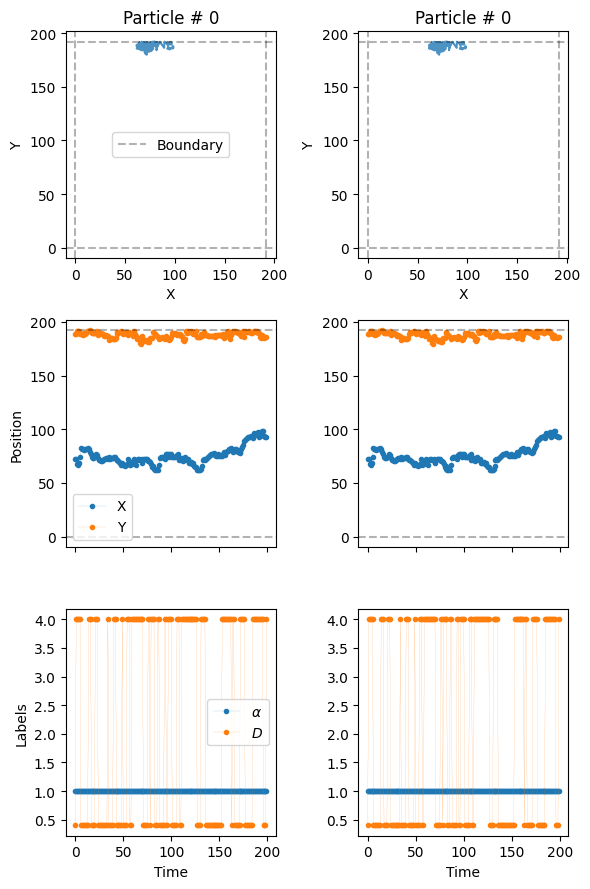

In [18]:
# alphas = np.random.uniform(0.1, 1.9, 1000) # 20 000
D = 0.4

# for i, alpha in tqdm(enumerate(alphas)):      

trajs, labels = models_phenom().multi_state(N = N, 
                                                L = L,
                                                T = T,
                                                alphas = [1.0, 1.0], # Fixed alpha for each state
                                                Ds = [10*D, D], # Mean and variance of each state
                                                M = [[0.8, 0.2], [0.2, 0.8]]
                                                )

plot_trajs(trajs, L, N, num_to_plot = 2, labels = labels, plot_labels = True, )

In [21]:
trajs = trajs[:,0,:]
labels = labels[:, : , 1]

bkps = np.where(labels[:-1, :] - labels[1:, :] != 0)[0]
bkps = np.append(bkps, 200)

In [23]:
from math import log
from ruptures.base import BaseCost


class MyCost(BaseCost):

    """Custom cost for exponential signals."""

    # The 2 following attributes must be specified for compatibility.
    model = ""
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self
    
    # def cost(self, params, start, end, trajs):

    #     alpha, K = params
    #     C = 0
    #     for t in range(start + 1 + 2, end):
    #         C -= np.log(1 / (4 * np.pi * K * t**alpha)) - (trajs[t, 0]**2 + trajs[t, 1]**2) / (4 * K * t**alpha)

    #     return C
    def cost(self, params, start, end, trajs):

        alpha, K = params
        C = 0
        for t in range(start + 1 + 2, end):
            C -= np.log((1 / (4 * np.pi * K * t**alpha)**(1/2)) * np.exp(-(trajs[t, 0]**2) / (4 * K * t**alpha)))

        return C
    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        self.cost_min = 1e10

        print(f'start = {start}')
        
        for _ in range(10):
        
            alpha = np.random.rand(1) * 2
            K = np.random.rand(1) * 100
            params = [alpha[0], K[0]]

            self.res = minimize(fun=self.cost, x0=params, args = (start, end, self.signal), method='L-BFGS-B',
                                bounds=((0.0, 2.0), (0.0, 300.0)),
                                options={'gtol': 1e-06, 'maxiter': 1000})

            if self.res.fun < self.cost_min:
                self.cost_min = self.res.fun
                self.params_opt = self.res.x


            print(self.res.fun)

        print(f'end = {end}')
        print(self.params_opt)

        return  self.res.fun


start = 0
11.291026769229498
11.291026769229346
11.291026769230502
11.291026769229347
11.29102676922956
11.291026769229344
11.291026769229347
11.291026769229344
11.291026769229344
11.291026769229344
end = 5
[  1.63575132 300.        ]
start = 0
40.47336561123388
40.473365611233945
40.473365611233895
40.47336561123396
40.47336561123391
40.47336561123387
40.4733656112339
40.47336561123387
40.47336561123387
40.47336561123387
end = 10
[  1.30363868 300.        ]
start = 5
11.63845133959683
11.636488055180573
11.635621439804753
11.638557109706543
11.63883106832262
11.63850663060927
11.638765625412292
11.635621439804753
11.635621439804753
11.635621439804808
end = 10
[  1.12180972 300.        ]
start = 5
40.79892970971175
40.79892970971207
40.79892970971175
40.798929709712205
40.79892970971191
40.79892970971185
40.79892970971179
40.798929709711764
40.798929709711764
40.798929709712176
end = 15
[  1.01109789 300.        ]
start = 10
11.652362336451413
11.652250479429341
11.652750737214731
11.6

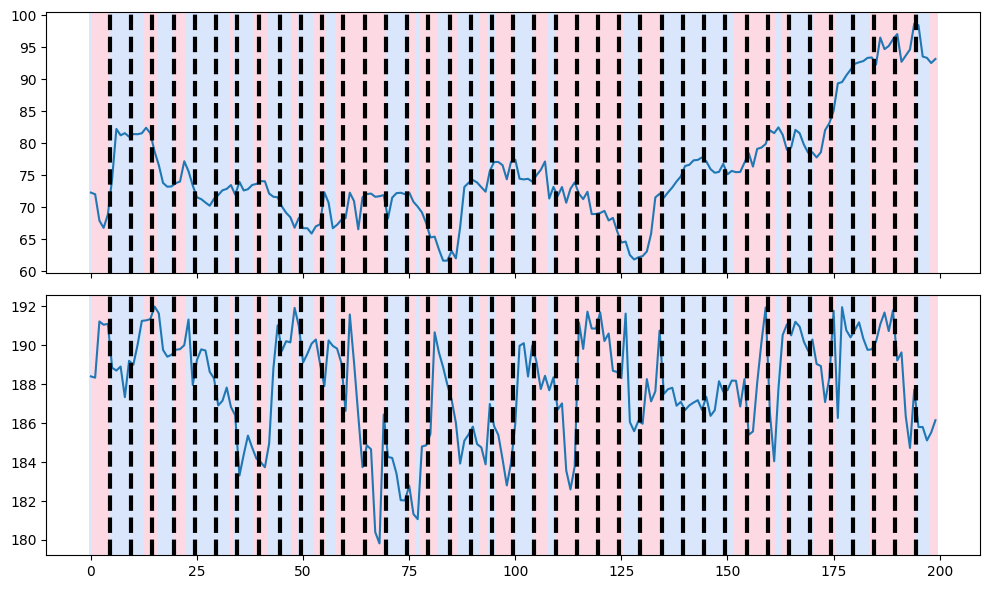

In [29]:
n, dim = 200, 2
# n_bkps, sigma = 3, 1

# change point detection
algo = rpt.Pelt(custom_cost=MyCost(), min_size=5).fit(trajs)
my_bkps = algo.predict(pen=5)

print(f'Number of detected cp: {len(my_bkps)}')
p, r = precision_recall(bkps, my_bkps, margin=3)

print(f'Pr = {p}, Recall =  {r}')


# show results
fig, ax_arr = rpt.display(trajs, bkps, my_bkps, figsize=(10, 6))
plt.show()